In [1]:
import numpy as np
import joblib
import scipy.io as sio
import pandas as pd

import xarray
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.linear_model import LinearRegression
from brainscore.metrics.regression import pearsonr
from sklearn.metrics import r2_score

import os


from brainio_base.assemblies import NeuronRecordingAssembly

from scipy import signal, interpolate
from scipy.signal import find_peaks, find_peaks_cwt

def apply_bandpass(data, fs, flow, fhigh):
    wl = flow / (fs / 2.)
    wh = fhigh / (fs / 2.)
    wn = [wl, wh]

    # Designs a 2nd-order Elliptic band-pass filter which passes
    # frequencies between 0.03 and 0.6, an with 0.1 dB of ripple
    # in the passband, and 40 dB of attenuation in the stopband.
    # The question is, do we really want to use IIR filter design?
    # Isn't it the case that IIR filters introduce refractory period
    # artifacts, and thus FIRs are preferred in practice?
    b, a = signal.ellip(2, 0.1, 40, wn, 'bandpass', analog=False)
    # To match Matlab output, we change default padlen from
    # 3*(max(len(a), len(b))) to 3*(max(len(a), len(b)) - 1)
    return signal.filtfilt(b, a, data, padlen=3*(max(len(a),len(b))-1))


def moving_average(x, w):
    w = int(w)
    return np.convolve(x, np.ones(w), 'same')



Loading lookup from /om/user/ssazaidi/miniconda3/envs/dicarlo_lab/lib/python3.7/site-packages/brainio_collection/lookup.csv


/om/user/ssazaidi/miniconda3/envs/dicarlo_lab/lib/python3.7/site-packages/brainscore/metrics/__init__.py:37: FutureWarning: xarray subclass Score should explicitly define __slots__
  class Score(DataAssembly):


In [2]:
rawDataPath = "/braintree/data2/active/users/ssazaidi/projects/stimulation/monkeys/oleo/"
directory_path = rawDataPath+"intanproc/oleo_stimulation_210820_121914/"


filename = directory_path+ "oleo_stimulation_210820_121914_psth.mat"

In [ ]:
psth = sio.loadmat(filename)

In [4]:
psth_data = psth['psth']

In [5]:
psth_data.shape

(105, 51, 120, 192)

In [6]:
np.sum(np.isnan(psth_data))/ psth_data.size

0.02875816993464052

In [7]:
psth_data_1 = psth_data[:,:25,...]
psth_data_2 = psth_data[:,25:50,...]

In [42]:
it_assembly = NeuronRecordingAssembly(psth_data)

In [71]:
stim_wise_psth = []
for i in range(psth_data.shape[0]):
    temp = psth_data[i,...]
    include_idx = np.unique(np.where(np.logical_not (np.isnan(temp)))[0])
    temp = temp[include_idx, ...]
    stim_wise_psth.append(temp)

In [75]:
re_psth_data = np.zeros([104, 50, 120,192])
stim_wise_psth = [i for i in stim_wise_psth if i.shape[0] > 0]
for i, stim_psth in enumerate(stim_wise_psth):
    re_psth_data[i,...] = stim_wise_psth[i][:50,...]

In [76]:
psth_data_1 = re_psth_data[:,:25,...]
psth_data_2 = re_psth_data[:,25:50,...]

In [ ]:
ceiling_obj_2 = brainscore.metrics.ceiling.InternalConsistency()
it_consistency = []

for t in range(it_assembly.shape[-1]):
    it_consistency.append(ceiling_obj_2(it_assembly[...,t]))


In [79]:
cIT_trial_average_binwise_a = np.mean(psth_data_1[...,96:], axis=1)
aIT_trial_average_binwise_a = np.mean(psth_data_1[...,:96], axis=1)
cIT_trial_average_binwise_b = np.mean(psth_data_2[...,96:], axis=1)
aIT_trial_average_binwise_b = np.mean(psth_data_2[...,:96], axis=1)

In [80]:
cIT_trial_average_shape = cIT_trial_average_binwise_a.shape
aIT_trial_average_shape = aIT_trial_average_binwise_a.shape

In [81]:
print(cIT_trial_average_shape,aIT_trial_average_shape)

(104, 120, 96) (104, 120, 96)


In [82]:
cIT_trial_average_binwise_a = cIT_trial_average_binwise_a.reshape(cIT_trial_average_shape[0],-1)
aIT_trial_average_binwise_a = aIT_trial_average_binwise_a.reshape(aIT_trial_average_shape[0],-1)
cIT_trial_average_binwise_b = cIT_trial_average_binwise_b.reshape(cIT_trial_average_shape[0],-1)
aIT_trial_average_binwise_b = aIT_trial_average_binwise_b.reshape(aIT_trial_average_shape[0],-1)

In [83]:
cIT_r2 = r2_score(cIT_trial_average_binwise_a,cIT_trial_average_binwise_b, multioutput='raw_values')
aIT_r2 = r2_score(aIT_trial_average_binwise_a,aIT_trial_average_binwise_b, multioutput='raw_values')

In [84]:
cIT_r2 = cIT_r2.reshape(cIT_trial_average_shape[1], cIT_trial_average_shape[2])
aIT_r2 = aIT_r2.reshape(aIT_trial_average_shape[1], aIT_trial_average_shape[2])

In [97]:
cIT_r2 = np.maximum(cIT_r2 , 0)
aIT_r2 = np.maximum(aIT_r2 , 0)

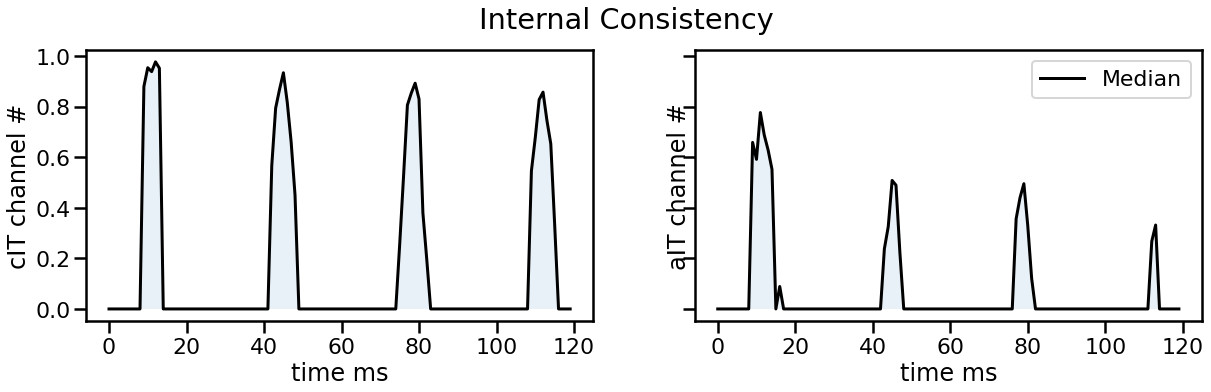

In [178]:
sns.set_context('poster')


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5), sharey=True)

# plt.subplot(1,2,1)
ax = axes[0]
im = ax.plot( np.max(cIT_r2,1), 'k')
# ax.grid(True)
ax.fill_between(np.arange(cIT_r2.shape[0]), np.min(cIT_r2,1), np.max(cIT_r2,1), alpha=0.1)
# plt.xticks(it_fr['time_bin_id'].data[:-1][0:50:10], it_fr['time_bin_start'].data[:-1][0:50:10])
ax.set_xlabel('time ms')
ax.set_ylabel('cIT channel #')


######### ignore negative r2 scores #########

# im = ax.plot(it_fr['time_bin_start'], np.median(np.maximum(cIT_r2,0),1), 'k')
# ax.fill_between(it_fr['time_bin_start'], np.min(np.maximum(cIT_r2,0),1), np.max(np.maximum(cIT_r2,0),1), alpha=0.
# im = ax.plot(it_fr['time_bin_start'], np.median(np.maximum(aIT_r2,0),1), 'k', label='Median')
# ax.fill_between(it_fr['time_bin_start'], np.min(np.maximum(aIT_r2,0),1), np.max(np.maximum(aIT_r2,0),1), alpha=0.1)

#############################################

ax = axes[1]


im = ax.plot( np.max(aIT_r2,1), 'k', label='Median')
ax.fill_between(np.arange(cIT_r2.shape[0]), np.min(aIT_r2,1), np.max(aIT_r2,1), alpha=0.1)
# plt.xticks(it_fr['time_bin_id'].data[:-1][0:50:10], it_fr['time_bin_start'].data[:-1][0:50:10])
ax.set_xlabel('time ms')

ax.set_ylabel('aIT channel #')
plt.legend()
# plt.grid(True)

plt.suptitle('Internal Consistency', y= 1)

plt.savefig('internal_consistency_2.jpg', dpi=300, bbox_inches='tight')

## Detect Artefact Onset

In [428]:
channel_letters = np.array(['a', 'b', 'c', 'd', 'e', 'f'])
channel_numbers = np.arange(32)


all_channels = np.array(np.meshgrid( channel_numbers, channel_letters))
all_channels = np.core.defchararray.add(np.core.defchararray.add(all_channels[1],'-'),np.char.zfill(all_channels[0], 3))
all_channels = all_channels.flatten()

In [429]:
np.where(all_channels == 'd-014')

(array([110]),)

In [430]:
date = '210823'
data_date = date
artefact_times = joblib.load(os.path.join('../spike_tools/', date, 'artefact_time_'+date+'.pkl')).astype(int)

samp_filename = '../spike_tools/'+data_date+'/samp_time_'+data_date+'.pkl'

if os.path.exists(samp_filename):
    samp_on = joblib.load(samp_filename)

In [431]:

artefact_files = [os.path.join('../spike_tools/', date, 'artefact_delays_'+data_date+'_'+i+'.pkl') for i in all_channels]
artefact_times = np.zeros([len(artefact_files), len(samp_on)]) 


for i, artefact_file in enumerate(artefact_files):
    try:
        artefact_info = joblib.load(os.path.join( artefact_file))
        artefact_times[i,:] = artefact_info['artefact_delay']

    except:
        print('Data Missing for channel ', artefact_file)

In [432]:
artefact_time = np.nanmedian(artefact_times, axis=0)

/om/user/ssazaidi/miniconda3/envs/dicarlo_lab/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [433]:
# artefact_times[:,751]

In [434]:
samplingFrequency = 20000
pre_ = 1000
post_ = 2000
length_ = pre_+post_
half_ = length_/(2*samplingFrequency)


channel_name = 'A-000'
directory_path = rawDataPath+"intanraw/oleo_stimulation_210823_120238/"
filename = os.path.join(directory_path , 'amp-'+channel_name+'.dat') # amplifier channel data
# filename = 'oleo_normalizers_210208_134001/amp-C-022.dat'
fid = open(filename, 'r')
filesize = os.path.getsize(filename) # in bytes
num_samples = filesize // 2 # int16 = 2 bytes
v = np.fromfile(fid, 'int16', num_samples)
fid.close()


v = v * 0.195 # convert to microvolts

sub_samp_on = []
artefact_on = []
sub_samp_number = []


failed_samp_on = []
failed_stim_number = []




shift = 0

sub_signals = np.zeros([len(samp_on), length_])

In [435]:
for idx, s in enumerate(samp_on[art_num:art_num+1]):
    i = idx
    i +=shift

    sub_signal = v[s-pre_: s+post_]
    band_pass_sub_signal = apply_bandpass(sub_signal, samplingFrequency, 300,5000)
    sub_signals[idx,:] = sub_signal

    peaks, _ = find_peaks(np.abs(band_pass_sub_signal), height=0, distance=75)
#     peaks = np.asarray([p for p in peaks if np.abs(band_pass_sub_signal[p]) > 20])  # Apply threshold
    temp = np.zeros_like(sub_signal)


    try:
        temp[peaks] = 1
        artefact_time = np.max(peaks[peaks < np.min(np.where(moving_average(temp, 10) > 1)[0]+9)])
        artefact_on.append(artefact_time)
        sub_samp_on.append(s)
        sub_samp_number.append(idx)
    except:
#         print('Missing stim on: ', s)
        failed_samp_on.append(s)
        failed_stim_number.append(idx)
        pass



In [436]:
art_num = 363

In [437]:
sub_signal = v[samp_on[art_num]-pre_: samp_on[art_num]+post_]
band_pass_sub_signal = apply_bandpass(sub_signal, samplingFrequency, 300,5000)

In [438]:
# peaks, _ = find_peaks(np.abs(band_pass_sub_signal), height=14)
vthres=200
peaks= np.array([])
while peaks.size < 5:
    peaks = find_peaks(np.abs(band_pass_sub_signal), vthres)[0]
    vthres = vthres*0.95
# peaks = np.asarray([p for p in peaks if np.abs(band_pass_sub_signal[p]) > 86])  # Apply threshold

In [439]:
temp = np.zeros_like(sub_signal)
temp[peaks] = 1

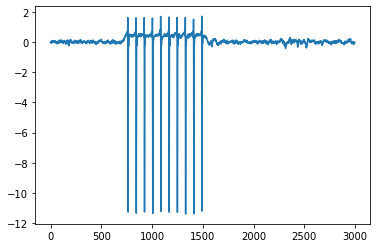

In [440]:
# plt.plot(temp)
plt.plot((band_pass_sub_signal - np.mean(band_pass_sub_signal))/np.std(band_pass_sub_signal))

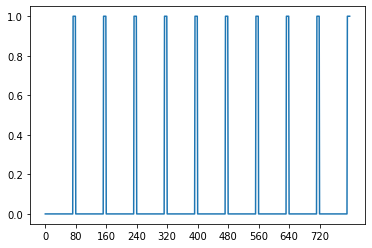

In [441]:
sum_window = 800
art_width_usec = 340
art_width = np.ceil(art_width_usec*samplingFrequency/1e6).astype(int)
pulse_train = np.zeros([sum_window,])
pulse_train[np.concatenate([i + np.arange(art_width) for i in np.arange(0,sum_window,int(sum_window/10))])] = 1
# pulse_train[np.concatenate([i + 4 + np.arange(3) for i in np.arange(0,sum_window,80)])] = 1
plt.plot(pulse_train[::-1])
plt.xticks(np.arange(0,800, 80));

In [442]:
art_width

7

800.0
758


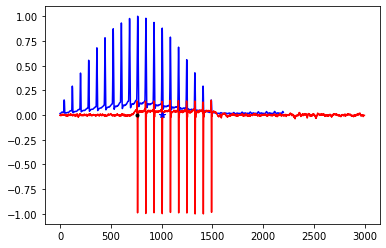

In [444]:
pulse_period_ms = 4 # seconds
num_pulses = 10
samplingFrequency = 20000
sum_window = (pulse_period_ms* num_pulses * samplingFrequency)/1000
print(sum_window)
# sig_av = moving_average(np.abs(temp), sum_window)
sig_av = np.convolve(np.abs(band_pass_sub_signal) , pulse_train[::-1], 'valid')
# print(np.argmax(sig_av) , len(sig_av), len(temp))
v_plot = plt.plot(sig_av/np.max(sig_av), 'b')
plt.plot(band_pass_sub_signal/np.max(np.abs(band_pass_sub_signal)), 'r')
# plt.plot(temp)
plt.plot(pre_, 0, 'b*')
art_start = int(np.argmax(sig_av)- art_width )
print(art_start)
plt.plot(art_start, 0, 'k.')

In [265]:
# np.where(artefact_times[:,art_num] - samp_on[art_num] < -500)
np.std(artefact_times[:,art_num] - samp_on[art_num])

-516.0

In [129]:
# start_ = -0
# end_= 2000
# plt.plot(np.arange(start_,end_), band_pass_sub_signal[art_start+start_:art_start +end_ ])
# # plt.plot( sub_signal[art_start: ])
# # plt.ylim([-2000, 1000])

874


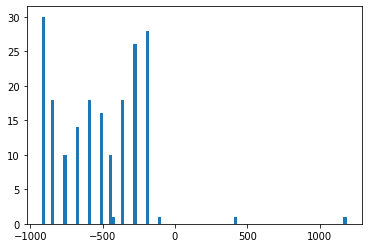

In [293]:
print(art_start - pre_)

h = plt.hist(artefact_times[:,art_num] - samp_on[art_num], 100)

In [261]:
artefact_time[art_num] - samp_on[art_num]

-516.0

In [67]:
%reset -f out
%reset -f in

Flushing output cache (13 entries)
Flushing input history


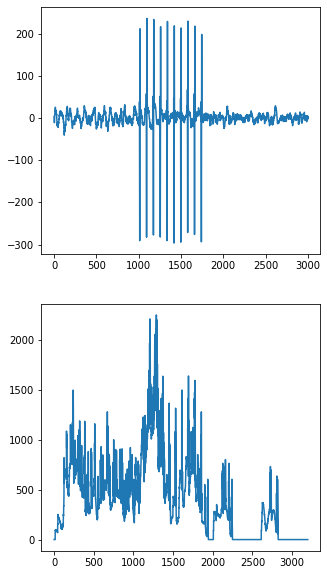

In [68]:
plt.figure(figsize=[5,10])
plt.subplot(2,1,1)
plt.plot(band_pass_sub_signal)
plt.subplot(2,1,2)
plt.plot(np.convolve(temp, np.abs(v[s-100:s+100])))

# Remove Artefacts

In [52]:
channel_letters = np.array(['a', 'b', 'c', 'd', 'e', 'f'])
channel_numbers = np.arange(32)


all_channels = np.array(np.meshgrid( channel_numbers, channel_letters))
all_channels = np.core.defchararray.add(np.core.defchararray.add(all_channels[1],'-'),np.char.zfill(all_channels[0], 3))
all_channels = all_channels.flatten()

In [88]:
date = '210820'
data_date = date
prefix = ''
artefact_times = joblib.load(os.path.join('../spike_tools/',prefix+ date, 'artefact_time_'+date+'.pkl'))

samp_filename = '../spike_tools/'+prefix+data_date+'/samp_time_'+data_date+'.pkl'

if os.path.exists(samp_filename):
    samp_on = joblib.load(samp_filename)

In [89]:
data_info = pd.read_csv('../spike_tools/datamaco-stim_corners-20210823-120237_mwk.csv')

In [90]:
samp_on_id = data_info.stim_id.values
samp_on_current = data_info.stim_current.values

In [91]:

artefact_files = [os.path.join('../spike_tools/', prefix+date, 'artefact_delays_'+data_date+'_'+i+'.pkl') for i in all_channels]
artefact_times = np.zeros([len(artefact_files), len(samp_on)]) 


for i, artefact_file in enumerate(artefact_files):
    try:
        artefact_info = joblib.load(os.path.join( artefact_file))
        artefact_times[i,:] = artefact_info['artefact_delay']

    except:
        print('Data Missing for channel ', artefact_file)

In [92]:
print(np.nanstd(artefact_times, axis=0), np.nanmean(artefact_times, axis=0), np.nanmedian(artefact_times, axis=0) )

[16.63728856 36.80016978 80.50703512 ... 54.48214918 22.56988027
 26.03065548] [4.71726552e+05 4.78117635e+05 4.84568115e+05 ... 2.10467036e+08
 2.10473471e+08 2.10480328e+08] [4.71727000e+05 4.78117000e+05 4.84562500e+05 ... 2.10467037e+08
 2.10473469e+08 2.10480328e+08]


In [94]:
artefact_times.shape

(192, 5312)

In [95]:
artefact_time = np.nanmedian(artefact_times, axis=0).astype(int)

In [96]:
bad_ones = []
for s in range(artefact_times.shape[1]):
#     print(s)
    if np.all(np.isnan(artefact_times[:,s])):
        bad_ones.append(s)
#         print(s)

In [98]:
bad_ones

[]

In [97]:
len(np.where(artefact_time < 0)[0])

0

In [85]:
# artefact_time[3141], samp_on_id[3141], samp_on_current[3141], np.where(np.logical_not( np.isnan(artefact_times[:,3141] )))
# all_channels[54]

# print([i for i in np.sum(np.isnan(artefact_times), axis=0)])
nan_sums = np.sum(np.isnan(artefact_times), axis=0)
bad_ones = np.where(nan_sums > 96)[0]
nan_sums = nan_sums[nan_sums > 0]
print(np.min(nan_sums), np.max(nan_sums) )

187 192


In [86]:
nan_sums = np.sum(np.isnan(artefact_times), axis=0)
good_ones = np.where(nan_sums < 96)[0]

In [14]:
good_ones = np.setdiff1d(np.arange(len(samp_on)), bad_ones)
print(len(good_ones))

5866


In [87]:
print(len(good_ones))

5866


In [15]:
samplingFrequency = 20000
pre_ = 1000
post_ = 2000
length_ = pre_+post_
half_ = length_/(2*samplingFrequency)


channel_name = 'B-022'
directory_path = rawDataPath+"intanraw/oleo_stimulation_210823_120238/"
filename = os.path.join(directory_path , 'amp-'+channel_name+'.dat') # amplifier channel data
# filename = 'oleo_normalizers_210208_134001/amp-C-022.dat'
fid = open(filename, 'r')
filesize = os.path.getsize(filename) # in bytes
num_samples = filesize // 2 # int16 = 2 bytes
v = np.fromfile(fid, 'int16', num_samples)
fid.close()


v = v * 0.195 # convert to microvolts

sub_samp_on = []
artefact_on = []
sub_samp_number = []


failed_samp_on = []
failed_stim_number = []




shift = 0

sub_signals = np.zeros([len(samp_on), length_])

In [32]:
# for idx, s in enumerate(artefact_time.astype(int)[0:365]):
#     i = idx
#     i +=shift

#     sub_signal = v[s-pre_: s+post_]
#     band_pass_sub_signal = apply_bandpass(sub_signal, samplingFrequency, 300,5000)
#     sub_signals[idx,:] = sub_signal

#     peaks, _ = find_peaks(np.abs(band_pass_sub_signal), height=0, distance=75)
# #     peaks = np.asarray([p for p in peaks if np.abs(band_pass_sub_signal[p]) > 20])  # Apply threshold
#     temp = np.zeros_like(sub_signal)

# #     print(data_info.iloc[i].stim_id, data_info.iloc[i].stim_current, i, 'th artefact SNR:', np.mean(sub_signal)/np.std(sub_signal))

#     try:
#         temp[peaks] = 1
#         artefact_time = np.max(peaks[peaks < np.min(np.where(moving_average(temp, 10) > 1)[0]+9)])
#         artefact_on.append(artefact_time)
#         sub_samp_on.append(s)
#         sub_samp_number.append(idx)
#     except:
# #         print('Missing stim on: ', s)
#         failed_samp_on.append(s)
#         failed_stim_number.append(idx)
#         pass



In [ ]:
# plt.plot(band_pass_sub_signal[pre_:])

In [17]:
def remove_artefacts_ind(signal, samp_on, fs=20000, art_time_usec=900, v_thres = 100):
    for i in range(len(samp_on)):
        pre_ = 0
        post_ = 880
        
        
        sub_signal = apply_bandpass(signal[samp_on[i]-pre_: samp_on[i]+post_], 20000, 300,6000)
        peaks = find_peaks(np.abs(sub_signal), v_thres)
        sub_signal = signal[samp_on[i]-pre_: samp_on[i]+post_]


        art_time_sec = art_time_usec/1e6
        art_len_pre = int(fs*art_time_sec/3)
        art_len_post = int(fs*art_time_sec)
#         print('Artefact length: ', art_len)



        start = -pre_
        x_ = []
        for peak in peaks[0]:
            x_.append(np.arange(start,peak - pre_ - art_len_pre))
            if peak - pre_ > start:
                start = peak - pre_ + art_len_post
        x_.append(np.arange(start, post_))
        x = np.concatenate(x_)
        interpolator_signal = interpolate.interp1d(x, sub_signal[x+pre_], fill_value='extrapolate')
        sig_interp = interpolator_signal(np.arange(-pre_,post_))

        signal[samp_on[i]-pre_: samp_on[i]+post_] = sig_interp
        
    return signal

In [18]:
def remove_artefacts_tala(signal, samp_on, fs=20000, art_time_usec=1200, v_thres = 100):
    signal = np.copy(signal)
    if type(art_time_usec) == list:
        art_time_usec = np.array(art_time_usec)
    elif type(art_time_usec) == int:
        art_time_usec = np.ones_like(samp_on)*art_time_usec
    else:
        assert type(art_time_usec) == np.ndarray
        
        
    for i, s in enumerate(samp_on):
        pre_ = 0
        post_ = 1000
        vthres = v_thres
        
        s = s-40
        
        sub_signal = apply_bandpass(signal[s-pre_: s+post_], 20000, 300,6000)
        peaks= np.array([])
        
        while not peaks.size:
            peaks = find_peaks(np.abs(sub_signal[:100]), vthres)[0]
            vthres = vthres*0.9

        sub_signal = signal[s-pre_: s+post_]
        try:
            first_peak = np.min(peaks)
        except:
            print("Error on Artefact number: " , i, 'peaks', peaks, v_thres)
            return

        if i == 751:
            print(first_peak)
            
        art_time_sec = art_time_usec[i]/1e6
        art_len_pre = np.ceil(fs*500/1e6)
        art_len_post = np.ceil(fs*art_time_sec)
#         peaks = np.concatenate([np.arange(i*80, i*80+art_len_post) for i in range(10)])

        x = np.setdiff1d(np.arange(-pre_, post_), (first_peak-art_len_pre) + np.concatenate([np.arange(i*81, i*81+art_len_post) for i in range(10)]))
#         x = np.setdiff1d(np.arange(-pre_, post_),  - art_len_pre + np.concatenate([np.arange(i*82, i*82+art_len_post) for i in range(10)]))
        interpolator_signal = interpolate.interp1d(x, sub_signal[x+pre_], fill_value='extrapolate')
        sig_interp = interpolator_signal(np.arange(-pre_,post_))

        signal[s-pre_: s+post_] = sig_interp
        
    return signal

In [19]:
%reset -f out
%reset -f in

Flushing output cache (2 entries)
Flushing input history


In [20]:
artefact_time_nan_removed = artefact_time[good_ones]

In [21]:
art_time_usec = 1200 + np.power(2, data_info['stim_current'].values/4.875)
v2 = remove_artefacts_tala(np.copy(v), artefact_time_nan_removed.astype(int), v_thres=400, art_time_usec=art_time_usec)
v_band_passed = apply_bandpass(v2, 20000, 300, 6000)

44


In [22]:
# art_time_usec = 1200 + 17*data_info['stim_current'].values
np.max(art_time_usec)

2120.4233965522353

In [23]:
len(artefact_time_nan_removed)

5866

In [24]:
# artefact_ranges = np.concatenate([[artefact_time - 100] , [artefact_time + 900]], axis=0).T
artefact_ranges = np.concatenate([[artefact_time_nan_removed - 100] , [artefact_time_nan_removed + 900]], axis=0).T
artefact_idcs = np.concatenate([np.arange(i[0],i[1]) for i in artefact_ranges])

Flushing output cache (2 entries)
Flushing input history


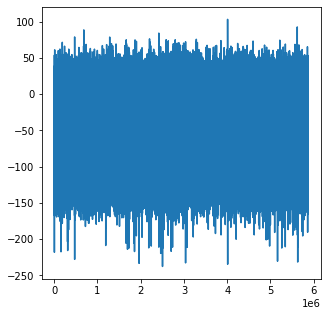

In [25]:
%reset -f out
%reset -f in
f = plt.figure(num = 1, figsize=[5,5])
ax = plt.plot(v_band_passed[artefact_idcs])#[artefact_time[580]-300:artefact_time[580]+1000])
plt.show()
plt.close()

In [26]:
boogers = np.where(v_band_passed[artefact_idcs] > 80)[0].reshape([-1,1])
boogers = artefact_idcs[boogers]

bad_ones = np.unique(np.where(np.logical_and(artefact_time.reshape([1,-1]) > boogers - 720, artefact_time.reshape([1,-1]) < boogers + 720))[1])
print(bad_ones, len(bad_ones))

[ 734 2603 4322 6057] 4


734 19924449


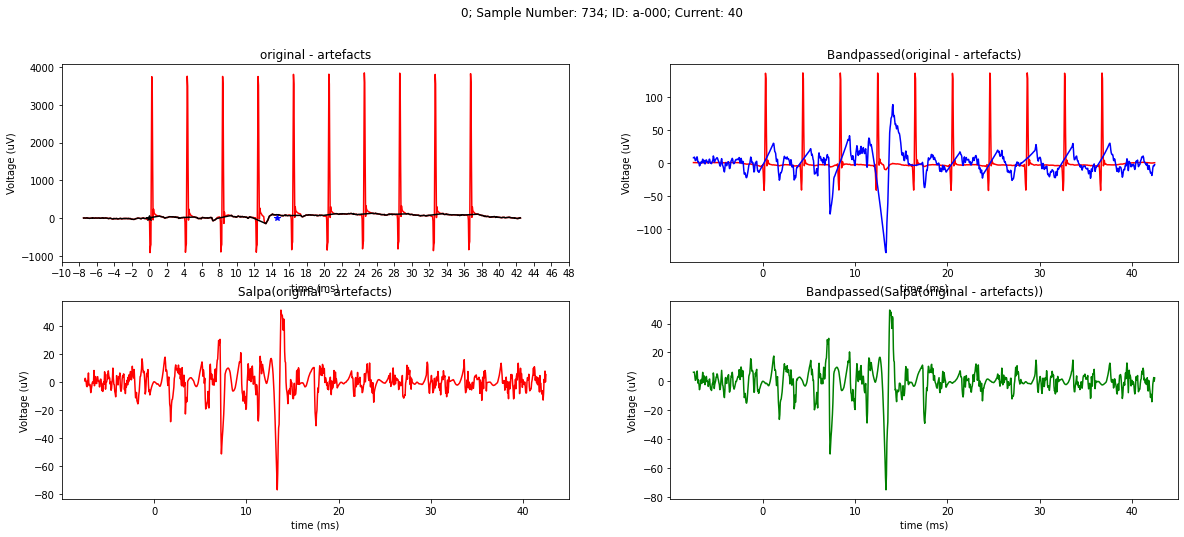

2603 79530997


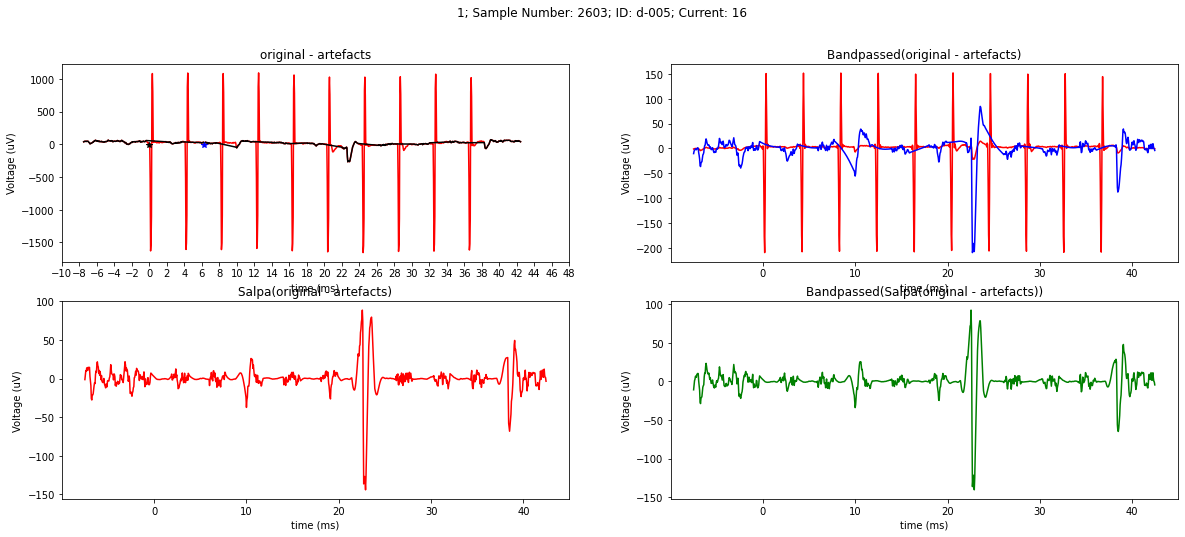

4322 155765408


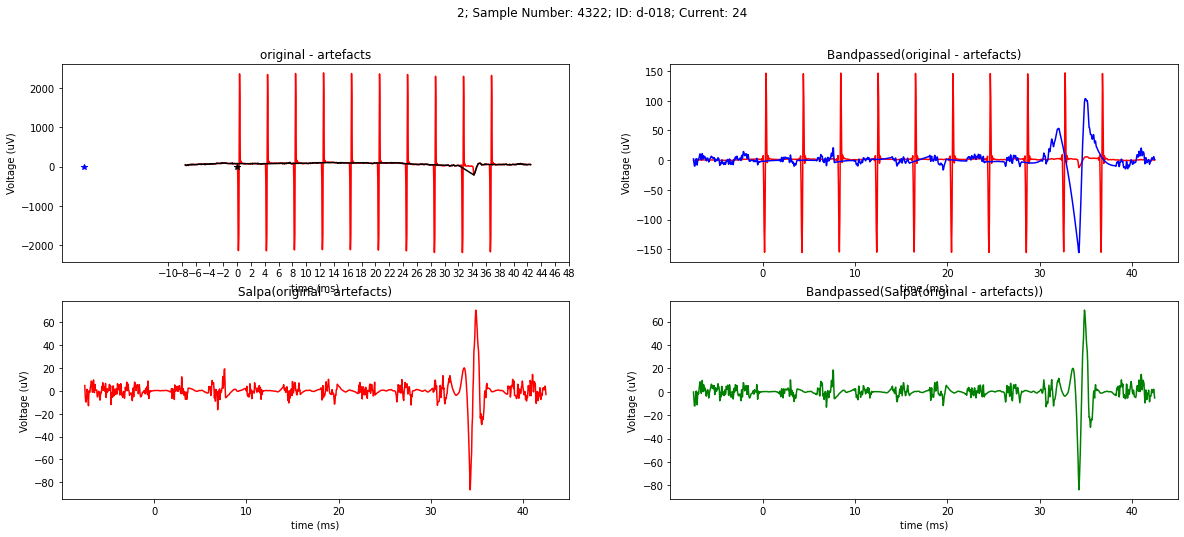

6057 210884098


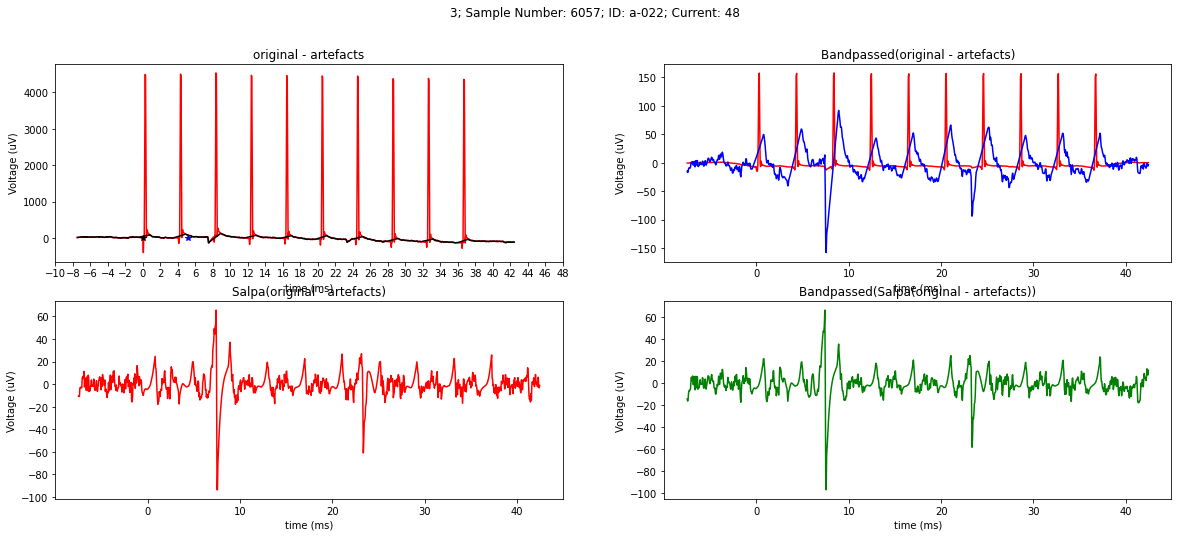

In [28]:
pre_ = 200
post_ = 900
stim_current = 48
stim_id = 'a-024'

sample_time = artefact_time.astype(int)
# sample_time = samp_on

# for rep_num, art_num in enumerate(np.where(np.logical_and(data_info['stim_id'] == stim_id , data_info['stim_current'] == stim_current))[0]):
# for rep_num, art_num in enumerate([362,616,1089,1111,1404,1943,2229,2881,3036,3039,3208,3514,3580,4773,4803,4862,4972]):
# for rep_num, art_num in enumerate([13]):
for rep_num, art_num in enumerate(bad_ones[:10]):
    print(art_num, sample_time[art_num])
    sub_signal_orig = v[sample_time[art_num]-pre_:sample_time[art_num]+post_]
    band_pass_sub_signal_orig = apply_bandpass(sub_signal_orig, samplingFrequency, 300,5000)

    sub_signal = v2[sample_time[art_num]-pre_:sample_time[art_num]+post_]
    band_pass_sub_signal = apply_bandpass(sub_signal, samplingFrequency, 300,5000)
    # plt.plot(sub_signal)

    w = 50
    new_signal = np.copy(sub_signal)
    for i in range(int(w/2), len(sub_signal)-int(w/2)):
        sig = sub_signal[i-int(w/2):i+int(w/2)]
        fitted_sig = np.polynomial.polynomial.polyfit(np.arange(len(sig)), sig, 3)
        t = np.arange(len(sig))
        pred_art = np.polynomial.polynomial.polyval(t, fitted_sig)
        new_signal[i] = new_signal[i] - pred_art[int(w/2)]


    band_pass_new_signal = apply_bandpass(new_signal, 20000,300,6000)

    t_ = np.arange(-pre_+w,post_-w)*1000/samplingFrequency

    plt.figure(figsize=[20,8])
    plt.subplot(221)

    plt.plot(t_,sub_signal_orig[w:-w], 'r')
    plt.plot(t_,sub_signal[w:-w], 'k', alpha=1)
    
    plt.plot(0,-10,'k*')
    plt.plot((samp_on[art_num] - sample_time[art_num])*1000/samplingFrequency,-10, 'b*')

    plt.title('original - artefacts')
    plt.xlabel('time (ms)')
    plt.ylabel('Voltage (uV)')
    plt.xticks(np.arange(-10,50,2))
    # plt.ylim([-150, 150])

    plt.subplot(222)
    plt.plot(t_,np.max(np.abs(band_pass_sub_signal[w:-w]))*band_pass_sub_signal_orig[w:-w]/np.max(np.abs(band_pass_sub_signal_orig[w:-w])), 'r')
    plt.plot(t_,band_pass_sub_signal[w:-w], 'b', alpha=1)
#     plt.plot(t_,band_pass_sub_signal[w:-w] - sub_signal[w:-w], 'b', alpha=0.5)



    plt.title('Bandpassed(original - artefacts)')
    plt.xlabel('time (ms)')
    plt.ylabel('Voltage (uV)')
  

    plt.suptitle(str(rep_num)+'; Sample Number: ' + str(art_num) + '; ID: '+samp_on_id[art_num] +'; Current: '+ str(samp_on_current[art_num]))
    

    plt.subplot(223)
    plt.plot(t_,new_signal[w:-w], 'r')
    plt.title('Salpa(original - artefacts)')
    plt.xlabel('time (ms)')
    plt.ylabel('Voltage (uV)')

    plt.subplot(224)
    plt.plot(t_,band_pass_new_signal[w:-w], 'g', alpha=1)
    plt.title('Bandpassed(Salpa(original - artefacts))')
    plt.xlabel('time (ms)')
    plt.ylabel('Voltage (uV)')
    
    plt.show()
    
    plt.close()



In [600]:
# np.where(np.logical_and(artefact_time > 217577600 - 1020000 , artefact_time  < 217577600 - 1015000))
np.where(np.logical_and(artefact_time > 9976844 - 1000 , artefact_time  < 9976844 + 1000))

(array([], dtype=int64),)

In [19]:
data_info.iloc[2238]

stim_on_time_ms                      100.0
stim_off_time_ms                     100.0
stim_on_delay_ms                     300.0
stimulus_size_degrees                    8
fixation_window_size_degrees             2
fixation_point_size_degrees            0.2
stim_id                              d-005
stim_current                            40
stimulus_presented                      26
fixation_correct                         1
stimulus_order_in_trial                  4
samp_on_us                      3501234150
photodiode_on_us                3501224600
Name: 2238, dtype: object

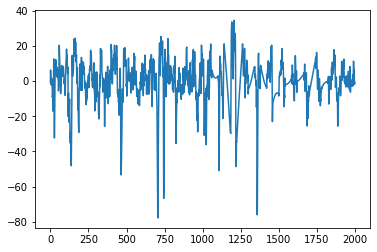

In [127]:
art_num = 747
sub_signal_orig = v[artefact_time[art_num]-1000:artefact_time[art_num]+1000]
band_pass_sub_signal_orig = apply_bandpass(sub_signal_orig, samplingFrequency, 300,5000)

sub_signal = v2[artefact_time[art_num]-1000:artefact_time[art_num]+1000]
band_pass_sub_signal = apply_bandpass(sub_signal, samplingFrequency, 300,5000)
# plt.plot(band_pass_sub_signal_orig)
plt.plot(band_pass_sub_signal)

w = 50
new_signal = np.copy(sub_signal)
for i in range(int(w/2), len(sub_signal)-int(w/2)):
    sig = sub_signal[i-int(w/2):i+int(w/2)]
    fitted_sig = np.polynomial.polynomial.polyfit(np.arange(len(sig)), sig, 3)
    t = np.arange(len(sig))
    pred_art = np.polynomial.polynomial.polyval(t, fitted_sig)
    new_signal[i] = new_signal[i] - pred_art[int(w/2)]
    
    
band_pass_new_signal = apply_bandpass(new_signal, 20000,300,6000)

In [408]:
data_info['stim_id'].unique()

array(['d-016', 'd-018', 'd-000', 'a-031', 'd-008', 'd-010', 'd-005',
       'a-000', 'a-016', 'a-028', 'a-022', 'd-025', 'b-000', 'b-031',
       'a-024'], dtype=object)

In [409]:
data_info['stim_current'].unique()

array([32, 24, 48,  8,  4, 16, 40])

In [49]:
# pre_ = 2000
# post_ = 2000
# stim_current = 48
# stim_id = 'a-024'
# # for rep_num, art_num in enumerate(np.where(np.logical_and(data_info['stim_id'] == stim_id , data_info['stim_current'] == stim_current))[0]):
# # for rep_num, art_num in enumerate([362,616,1089,1111,1404,1943,2229,2881,3036,3039,3208,3514,3580,4773,4803,4862,4972]):
# for rep_num, art_num in enumerate(bad_ones):

#     sub_signal_orig = v[artefact_time[art_num]-pre_:artefact_time[art_num]+post_]
#     band_pass_sub_signal_orig = apply_bandpass(sub_signal_orig, samplingFrequency, 300,5000)

#     sub_signal = v2[artefact_time[art_num]-pre_:artefact_time[art_num]+post_]
#     band_pass_sub_signal = apply_bandpass(sub_signal, samplingFrequency, 300,5000)
#     # plt.plot(sub_signal)

#     w = 50
#     new_signal = np.copy(sub_signal)
#     for i in range(int(w/2), len(sub_signal)-int(w/2)):
#         sig = sub_signal[i-int(w/2):i+int(w/2)]
#         fitted_sig = np.polynomial.polynomial.polyfit(np.arange(len(sig)), sig, 3)
#         t = np.arange(len(sig))
#         pred_art = np.polynomial.polynomial.polyval(t, fitted_sig)
#         new_signal[i] = new_signal[i] - pred_art[int(w/2)]


#     band_pass_new_signal = apply_bandpass(new_signal, 20000,300,6000)

#     t_ = np.arange(-pre_+w,post_-w)

#     plt.figure(figsize=[20,8])
#     plt.subplot(221)

#     plt.plot(t_,sub_signal_orig[w:-w], 'r')
#     plt.plot(t_,sub_signal[w:-w], 'k', alpha=1)
#     plt.plot(0,-10,'k*')
#     plt.plot(samp_on[art_num] - artefact_time[art_num],-10, 'b*')

#     plt.title('original - artefacts')
#     # plt.ylim([-150, 150])

#     plt.subplot(222)
#     plt.plot(t_,band_pass_sub_signal_orig[w:-w], 'r')
#     plt.plot(t_,band_pass_sub_signal[w:-w], 'b', alpha=1)
# #     plt.plot(t_,band_pass_sub_signal[w:-w] - sub_signal[w:-w], 'b', alpha=0.5)



#     plt.title('Bandpassed(original - artefacts)')

#     plt.subplot(223)
#     plt.plot(t_,new_signal[w:-w], 'r')
#     plt.title('Salpa(original - artefacts)')

#     plt.subplot(224)
#     plt.plot(t_,band_pass_new_signal[w:-w], 'g', alpha=1)
#     plt.title('Bandpassed(Salpa(original - artefacts))')

#     plt.suptitle(str(rep_num)+'; Sample Number: ' + str(art_num))
#     plt.show()
#     plt.close()



In [351]:
artefact

(array([], dtype=int64),)

###### data_info.iloc[15]

## Apply Salpa on entire signal

In [ ]:
w = 50
pre_ = 100
post_ = 850

v2_salpa = np.copy(v2)

for art_num, art_start in enumerate(artefact_time_nan_removed):

    sub_signal = v2[art_start-pre_:art_start+post_]
    band_pass_sub_signal = apply_bandpass(sub_signal, samplingFrequency, 300,5000)
    new_signal = np.copy(sub_signal)
    
    for i in range(int(w/2), len(sub_signal)-int(w/2)):
        sig = sub_signal[i-int(w/2):i+int(w/2)]
        fitted_sig = np.polynomial.polynomial.polyfit(np.arange(len(sig)), sig, 3)
        t = np.arange(len(sig))
        pred_art = np.polynomial.polynomial.polyval(t, fitted_sig)
        new_signal[i] = new_signal[i] - pred_art[int(w/2)]

    v2_salpa[art_start-pre_:art_start+post_] = new_signal
    

In [644]:
v_salpa_band_passed = apply_bandpass(v2_salpa, 20000,300,6000)

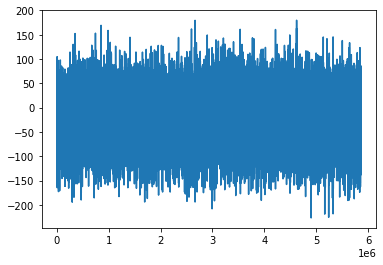

In [645]:
v_plot = plt.plot(v_salpa_band_passed[artefact_idcs])

plt.show()
plt.close()

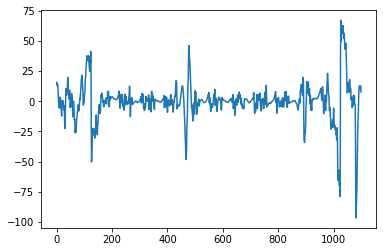

In [658]:
art_num = good_ones[10]
pre_ = 200
post_ = 900
sub_signal = v_salpa_band_passed[artefact_time[art_num]-pre_ :artefact_time[art_num]+post_ ]

plt.plot(sub_signal)

In [204]:
start_ = 250
sig = sub_signal[start_:start_+50]

In [205]:
fitted_sig = np.polynomial.polynomial.polyfit(np.arange(len(sig)), sig, 3)

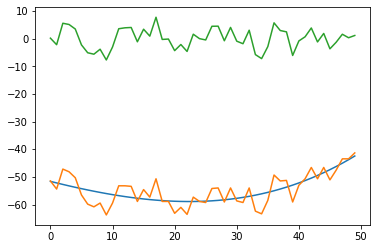

In [24]:
t = np.arange(len(sig))
pred_art = np.polynomial.polynomial.polyval(t, fitted_sig)
plt.plot(t, pred_art)
plt.plot(t, sig)

plt.plot(t, sig-pred_art)

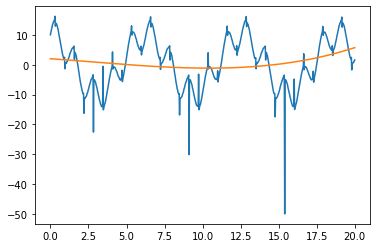

In [368]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(12)

num_samples = 800

x = np.linspace(0, 20, num_samples)
y = 5*np.sin(5*x) + 10*np.cos(x) + 0.3*np.random.rand(num_samples) + np.tan(5*x)/10
p = np.poly1d(np.polyfit(x, y, 3))

t = np.linspace(0, 20, 200)
plt.plot(x, y, '-', t, p(t), '-')
plt.show()

In [426]:
### Initialize Salpa ###

N = 50
max_poly = 3

T = np.array([np.sum(np.power(np.arange(-N, N+1), i)) for i in range(max_poly*2 + 1)])
S = np.zeros([max_poly+1,max_poly+1])
for i in np.arange(max_poly+1):
    for j in np.arange(max_poly+1):
        S[i,j] = T[i+j]

coeff = np.zeros_like(S)
for k in range(max_poly+1):
    p1 = np.power((-1),np.arange(0,k+1))
    l_facts = np.array([np.math.factorial(i) for i in np.arange(k+1)])
    kl_facts = l_facts[::-1]
    coeff_term = np.math.factorial(k)*p1/(l_facts*kl_facts)
    coeff[k, :len(coeff_term)] = coeff_term

coeff_for = np.array([N**i for i in range(max_poly+1)])
coeff_back = np.array([-(-N-1)**i for i in range(max_poly+1)])

In [427]:
coeff_for, coeff_back

(array([     1,     50,   2500, 125000]),
 array([    -1,     51,  -2601, 132651]))

In [428]:
import time

0.057736873626708984


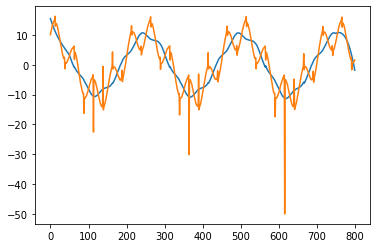

In [448]:
#### Method of Choice for now ####

start = time.time()
y_fit_complete = np.zeros_like(y)

nc = N
V = y[nc-N:nc+N+1]
W = np.array([np.sum(V*np.power(np.arange(-N, N+1), i)) for i in range(max_poly+1)])

a = np.linalg.inv(S)@W
y_ = a.T@np.array([np.power(np.arange(-N, N+1), i) for i in range(max_poly+1)])
y_fit_complete[:nc+1] = y_[:nc+1]

for nc_idx , nc in enumerate( np.arange(N+1, len(y)-N )):
    V = y[nc-N:nc+N+1]
    
    W = np.array([np.sum(V*np.power(np.arange(-N, N+1), i)) for i in range(max_poly+1)])
    
    a = np.linalg.inv(S)@W
    y_fit_complete[nc] = a[0]
        
y_ = a.T@np.array([np.power(np.arange(-N, N+1), i) for i in range(max_poly+1)])
y_fit_complete[nc:] = y_[N:]

end = time.time()
diff = end - start
print(diff)
plt.plot(y_fit_complete)
plt.plot(y)

0.0015285015106201172


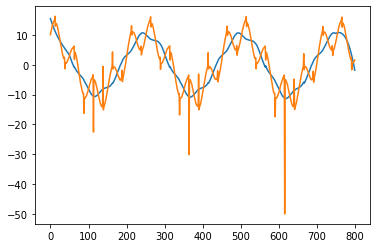

In [462]:
#### The real MVP ####
start = time.time()

y_fit_complete = np.zeros_like(y)
W = np.array([np.convolve(y,np.power(np.arange(-N, N+1), i)[::-1], 'valid') for i in range(max_poly+1)])
a = np.linalg.inv(S)@W
y_fit_complete[N:-N] = a[0]
y_fit_complete[:N] = (a[:,0].T@np.array([np.power(np.arange(-N, N+1), i) for i in range(max_poly+1)]))[:N]


y_fit_complete[-N-1:] = (a[:,-1].T@np.array([np.power(np.arange(-N, N+1), i) for i in range(max_poly+1)]))[N:]

end = time.time()
diff = end-start

print(diff)
plt.plot(y_fit_complete)
plt.plot(y)

In [457]:
nc = N
V = y[nc-N:nc+N+1]
W = np.array([np.sum(V*np.power(np.arange(-N, N+1), i)) for i in range(max_poly+1)])
W

array([ 2.45010423e+02, -2.15606497e+04,  1.55265635e+05, -3.45524167e+07])

In [460]:
np.array([np.convolve(y,np.power(np.arange(-N, N+1), i)[::-1], 'valid') for i in range(max_poly+1)])[:,0]

array([ 2.45010423e+02, -2.15606497e+04,  1.55265635e+05, -3.45524167e+07])

In [433]:
a = np.linalg.inv(S)@W

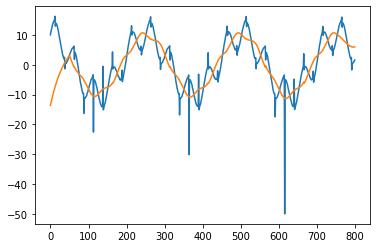

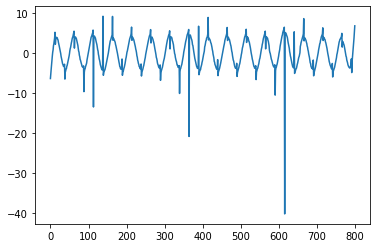

In [390]:
plt.plot(y - y_fit_complete)

0.0595090389251709

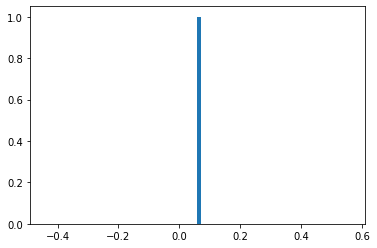

In [391]:
h1 = plt.hist(diff, 100)
np.mean(diff)

In [392]:
y[200+N+1]

4.733385176061754

0.02023792266845703


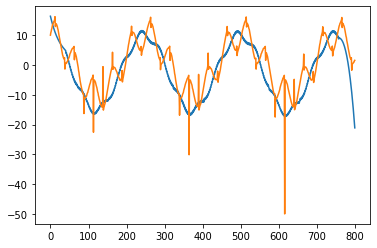

In [393]:
start = time.time()

y_fit_closed = np.zeros_like(y)

nc = N
V = y[nc-N:nc+N+1]
W = np.array([np.sum(V*np.power(np.arange(-N, N+1), i)) for i in range(max_poly+1)])

a = np.linalg.inv(S)@W
y_ = a.T@np.array([np.power(np.arange(-N, N+1), i) for i in range(max_poly+1)])
y_fit_closed[:nc+1] = y_[:nc+1]

for nc_idx , nc in enumerate( np.arange(N+1, len(y)-N -1)):
    W = coeff@W - y[nc-N]*coeff_back - y[nc+N+1]*coeff_for
    a = np.linalg.inv(S)@W
    y_fit_closed[nc] = a[0]
      
y_ = a.T@np.array([np.power(np.arange(-N, N+1), i) for i in range(max_poly+1)])
y_fit_closed[nc+1:] = y_[N:]
end = time.time()

diff = end - start
print(diff)
plt.plot(y_fit_closed)
plt.plot(y)

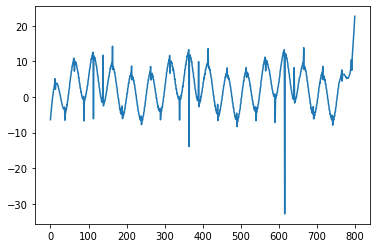

In [394]:
plt.plot(y - y_fit_closed)

0.02023792266845703

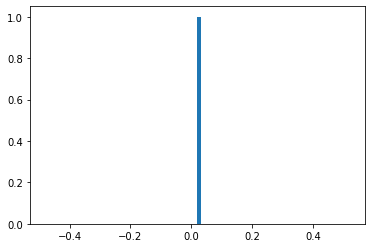

In [395]:
h2 = plt.hist(diff, 100)
np.mean(diff)

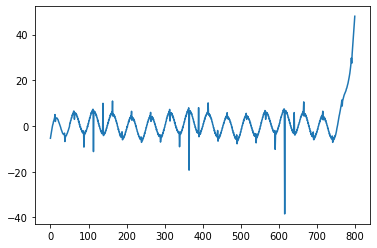

In [396]:
plt.plot(y-y_fit)

In [397]:
W_1 = coeff@W + y[nc-N]*np.array([N**i for i in range(4)]) - y[nc+N+1]*np.array([(-N-1)**i for i in range(4)])

In [398]:
W_1

array([ 2.53342031e+02,  1.00667347e+04, -4.79885065e+04,  1.10898240e+07])

In [399]:
y_ = a.T@np.array([np.power(np.arange(-N, N+1), i) for i in range(4)])

0.22063827514648438


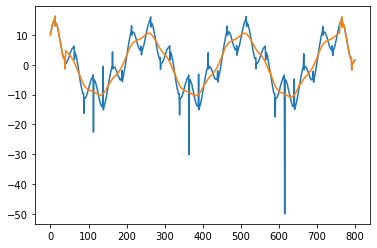

In [400]:
start = time.time()
w = 2*N
sub_signal = y
new_signal = np.copy(sub_signal)
for i in range(int(w/2), len(sub_signal)-int(w/2)):
    sig = sub_signal[i-int(w/2):i+int(w/2)]
    fitted_sig = np.polynomial.polynomial.polyfit(np.arange(len(sig)), sig, 3)
    t = np.arange(len(sig))
    pred_art = np.polynomial.polynomial.polyval(t, fitted_sig)
    new_signal[i] = pred_art[int(w/2)]
end = time.time()
diff = end - start
print(diff)
plt.plot(sub_signal)
plt.plot(new_signal)

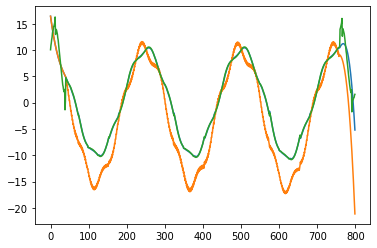

In [401]:
plt.plot(y_fit_complete)
plt.plot(y_fit_closed)
plt.plot(new_signal)

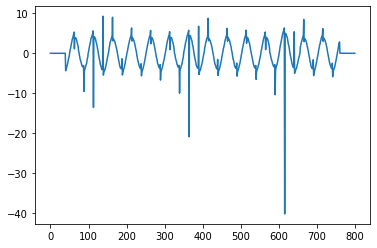

In [402]:
plt.plot(sub_signal-new_signal)

In [36]:
np.nan/1000 <19

False